**20MAI1019**

# AMAZON REVIEW CLASSIFICATION

In this notebook iam going to implement a review classification model using Bert model. pretrained Bert models are available
on tfhub modules and can also be implemented using Hugging face library.
In this notebook iam going to use Hugging face library.

The dataset can be downloaded using this link https://www.kaggle.com/bittlingmayer/amazonreviews

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

     |████████████████████████████████| 2.0MB 7.5MB/s 
     |████████████████████████████████| 3.2MB 50.3MB/s 
     |████████████████████████████████| 890kB 51.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=8f91f74dce9427e097c9609a56d1f1fc89dac767f3f12419e792b68decc29a39
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
#importing relevant libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import Dense, Input, Dropout
from sklearn.utils import shuffle
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

In [4]:
import bz2 
train_file = bz2.BZ2File('/content/drive/MyDrive/train.ft.txt.bz2')
test_file = bz2.BZ2File('/content/drive/MyDrive/test.ft.txt.bz2')

In [5]:
train_file_lines = train_file.readlines()
test_file_lines = test_file.readlines()

In [6]:
train_file_lines[0]

b'__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n'

In [7]:
train_file_lines[10]

b"__label__1 The Worst!: A complete waste of time. Typographical errors, poor grammar, and a totally pathetic plot add up to absolutely nothing. I'm embarrassed for this author and very disappointed I actually paid for this book.\n"

In [8]:
del train_file, test_file

In [9]:
train_file_lines = [x.decode('utf-8') for x in train_file_lines]
test_file_lines = [x.decode('utf-8') for x in test_file_lines]

In [10]:
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file_lines]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file_lines]

test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file_lines]
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_file_lines]

In [11]:
train_sentences[0]

'stuning even for the non-gamer: this sound track was beautiful! it paints the senery in your mind so well i would recomend it even to people who hate vid. game music! i have played the game chrono cross but out of all of the games i have ever played it has the best music! it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. it would impress anyone who cares to listen! ^_^'

**Text Cleaning**

In [12]:
import re

for i in range(len(train_sentences)):
    train_sentences[i] = re.sub('\d','0',train_sentences[i])
    
for i in range(len(test_sentences)):
    test_sentences[i] = re.sub('\d','0',test_sentences[i])
for i in range(len(train_sentences)):
    if 'www.' in train_sentences[i] or 'http:' in train_sentences[i] or 'https:' in train_sentences[i] or '.com' in train_sentences[i]:
        train_sentences[i] = re.sub(r"([^ ]+(?<=\.^![a-z]{3}))", "<url>", train_sentences[i])
        
for i in range(len(test_sentences)):
    if 'www.' in test_sentences[i] or 'http:' in test_sentences[i] or 'https:' in test_sentences[i] or '.com' in test_sentences[i]:
        test_sentences[i] = re.sub(r"([^ ]+(?<=\.^![a-z]{3}))", "<url>", test_sentences[i])


In [13]:
train_sentences[0]

'stuning even for the non-gamer: this sound track was beautiful! it paints the senery in your mind so well i would recomend it even to people who hate vid. game music! i have played the game chrono cross but out of all of the games i have ever played it has the best music! it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. it would impress anyone who cares to listen! ^_^'

In [14]:
test_sentences[0]

'great cd: my lovely pat has one of the great voices of her generation. i have listened to this cd for years and i still love it. when i\'m in a good mood it makes me feel better. a bad mood just evaporates like sugar in the rain. this cd just oozes life. vocals are jusat stuunning and lyrics just kill. one of life\'s hidden gems. this is a desert isle cd in my book. why she never made it big is just beyond me. everytime i play this, no matter black, white, young, old, male, female everybody says one thing "who was that singing ?"'

In [15]:
docSentimentList=[]
def getDocumentSentimentList(docs,splitStr='__label__'):
    for i in range(len(docs)):
        #print('Processing doc ',i,' of ',len(docs))
        text=str(train_file_lines[i])
        #print(text)
        splitText=text.split(splitStr)
        secHalf=splitText[1]
        text=secHalf[2:len(secHalf)-1]
        sentiment=secHalf[0]
        #print('First half:',secHalf[0],'\nsecond half:',secHalf[2:len(secHalf)-1])
        docSentimentList.append([text,sentiment])
    print('Done!!')
    return docSentimentList

In [16]:
docSentimentList=getDocumentSentimentList(train_file_lines[:1000000],splitStr='__label__')

Done!!


In [20]:
train_sentences_df = pd.DataFrame(docSentimentList, columns = ['review','Sentiment'])
train_sentences_df.head()

,review,Sentiment
0,Stuning even for the non-gamer: This sound tra...,2
1,The best soundtrack ever to anything.: I'm rea...,2
2,Amazing!: This soundtrack is my favorite music...,2
3,Excellent Soundtrack: I truly like this soundt...,2
4,"Remember, Pull Your Jaw Off The Floor After He...",2


In [21]:
train_sentences_df['word_count'] = train_sentences_df['review'].apply(lambda x : len(x.split()))
train_sentences_df['char_count'] = train_sentences_df['review'].apply(lambda x : len(x.replace(" ","")))
train_sentences_df['word_density'] = train_sentences_df['word_count'] / (train_sentences_df['char_count'] + 1)

In [22]:
train_sentences_df.head()

,review,Sentiment,word_count,char_count,word_density
0,Stuning even for the non-gamer: This sound tra...,2,80,347,0.229885
1,The best soundtrack ever to anything.: I'm rea...,2,97,413,0.234300
2,Amazing!: This soundtrack is my favorite music...,2,129,632,0.203791
3,Excellent Soundtrack: I truly like this soundt...,2,118,626,0.188198
4,"Remember, Pull Your Jaw Off The Floor After He...",2,87,395,0.219697


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

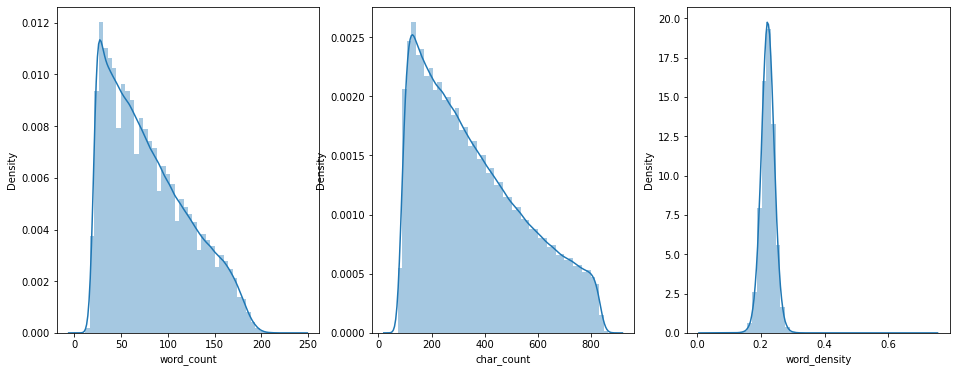

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(16, 6))
dp=sns.distplot(train_sentences_df['word_count'],ax=ax[0])
dp=sns.distplot(train_sentences_df['char_count'],ax=ax[1])
dp=sns.distplot(train_sentences_df['word_density'],ax=ax[2])
plt.show()

In [25]:
train_sentences_df.describe()

,word_count,char_count,word_density
count,1000000.000000,1000000.000000,1000000.000000
mean,79.380672,358.545564,0.222194
std,43.075900,196.661356,0.021235
min,2.000000,57.000000,0.010256
25%,43.000000,192.000000,0.208537
50%,71.000000,319.000000,0.222222
75%,109.000000,495.000000,0.235849
max,241.000000,882.000000,0.750000


In [28]:
train_sentences_df['Sentiment'][train_sentences_df['Sentiment']=='1'] = 0
train_sentences_df['Sentiment'][train_sentences_df['Sentiment']=='2'] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
train_sentences_df['Sentiment'].value_counts()

1    505678
0    494322
Name: Sentiment, dtype: int64

In [32]:
train_sentences_df['word_count'] = train_sentences_df['review'].str.lower().str.split().apply(len)
train_sentences_df.head()

,review,Sentiment,word_count,char_count,word_density
0,Stuning even for the non-gamer: This sound tra...,1,80,347,0.229885
1,The best soundtrack ever to anything.: I'm rea...,1,97,413,0.234300
2,Amazing!: This soundtrack is my favorite music...,1,129,632,0.203791
3,Excellent Soundtrack: I truly like this soundt...,1,118,626,0.188198
4,"Remember, Pull Your Jaw Off The Floor After He...",1,87,395,0.219697


**BERT Classifier**

In [ ]:
MAX_SEQUENCE_LENGTH = 300
TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 64
truncation_strategy = 'longest_first' #the tokenizer truncates the longer sentence first
Tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

The dataset consists of 4 million review with 90% of them for training and the rest is for testing

In [ ]:
#helper functions to prepare the data

def split_from_label(line):
    return ' '.join(line.split(' ')[1:])

def map_label(row):
    if row == '__label__1':
        return 0
    else:
        return 1 

Each record in the dataset composed of three parts.

1 - The label in the form _ _ _label_ _ _  + 1 or 2 for good or bad reviews

2 - the head of the review ending with :

3 - the body of the review

The following function takes the text file object and returns a data frame with a separate column for each part

In [ ]:
def prepare_dataset(text_file):
    df = pd.DataFrame(text_file, columns = ['original_text'])
    df['head'] = df['original_text'].str.split(':').str.get(0).map(split_from_label).astype('str')
    df['body'] = df['original_text'].str.split(':').str.get(1).astype('str')
    df['label'] = df['original_text'].str.split(':').str.get(0).str.extract(r'(__label__[1-2])').astype('str')
    df['label'] = df['label'].map(map_label)
    df.drop('original_text',1,inplace = True)
    df = shuffle(df)
    return df

train_dataset = prepare_dataset(train_file)
test_dataset = prepare_dataset(test_file)

Bert tokenizer has its own way of tokenization, It takes a sentence and optionally another sentence and converts them into an input suitable for Bert model.

The output of tokenizer encoding method is a dictionary contains the following:

1 - the indices of the words of the two sentences separated by [SEP] token and before them the indix of the [CLS] token (in case 'add_special_tokens' argument is set to True)

2 - binary array indicating the non padded part of the sequence needed for attention (1 for non padded and 0 for padded)

3 - another binary array indicating which part of the total sequence belongs to sentence 1 and which part belongs to sequence 2

In [ ]:
#function to convert text into suitable Bert input form
def get_model_inputs(str1, str2, _truncation_strategy, length, tokenizer, pad_seq = True):

    inputs = tokenizer.encode_plus(str1,
                                    str2,
                                    add_special_tokens=True,
                                    max_length=length,
                                    truncation_strategy=_truncation_strategy,
                                    pad_to_max_length=pad_seq)

    input_ids = inputs["input_ids"]
    input_masks = inputs["attention_mask"]
    input_segments = inputs["token_type_ids"]
    return [input_ids, input_masks, input_segments]

In [ ]:
#custom data generator to feed the data to the odel batch by batch
def datagen(dataset, batch_size):
  data = dataset.copy()
  while True:
    for i in range(1):
      inputs_x_id, inputs_x_mask, inputs_x_segment, inputs_y = [], [], [], []
      start = i*batch_size
      end = start+batch_size
      batch_x = data.iloc[start:end,[0, 1]].values
      batch_y = data.iloc[start:end,2].values
      for i in range(batch_size):
        input_ids, input_masks, input_segments = get_model_inputs(batch_x[i,0], batch_x[i,1], 
                                                                  truncation_strategy, 
                                                                  MAX_SEQUENCE_LENGTH, 
                                                                  Tokenizer)
        
        inputs_x_id.append(input_ids)
        inputs_x_mask.append(input_masks)
        inputs_x_segment.append(input_segments)
        inputs_y.append(batch_y[i])

      yield ([np.array(inputs_x_id, dtype=np.int32),
             np.array(inputs_x_mask, dtype=np.int32),
             np.array(inputs_x_segment, dtype=np.int32)],
             np.array(inputs_y, dtype=np.int32))

K.clear_session()
train_data_generator = datagen(train_dataset, TRAIN_BATCH_SIZE)
test_data_generator = datagen(test_dataset, TEST_BATCH_SIZE)

The model takes the output hidden state of the last layer for all tokens, average pooling them then to a dense layer

You can edit the configurations the pass the edited dictionary to the TFBertModel

In [ ]:
def create_model():
    input_id = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    input_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    input_atn = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    config = BertConfig() 
    config.output_hidden_states = False # Set to True to obtain hidden states
    
    bert_model = TFBertModel.from_pretrained('bert-base-uncased', config=config)
    
    # if config.output_hidden_states = True, obtain hidden states via bert_model(...)[-1]
    input_embedding = bert_model(input_id, attention_mask=input_mask, token_type_ids=input_atn)[0]

    # Get average tokens output
    tokens_embedding = tf.keras.layers.GlobalAveragePooling1D()(input_embedding)
    
    x = tf.keras.layers.Dense(128, activation='relu')(tokens_embedding)
        
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs=[input_id, input_mask, input_atn], outputs=x)
    
    return model

bert = create_model();

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [ ]:
#loss function (modified binary cross entropy loss function which gives higher attention to misclassified examples)
def focal_loss(y_true, y_pred, gamma=2., alpha=.25):
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

In [ ]:
early_stopping = EarlyStopping(monitor= 'val_acc', 
                               mode = 'max',
                               patience=30, 
                               verbose=1)

model_checkpoint = ModelCheckpoint('BERT_MODEL_AMAZON_REVIEW_CLASSIFIER',
                                   monitor = 'val_acc', 
                                   mode = 'max', 
                                   save_best_only=True, 
                                   verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', 
                              mode = 'max',
                              factor=0.2, 
                              patience=4, 
                              min_lr=0.0000001, 
                              verbose=1)
opt = Adam(lr = 0.0005)
bert.compile(loss = focal_loss, optimizer= opt, metrics=['acc'])

In [ ]:
#train the model
history = bert.fit(x=train_data_generator,
                    validation_data=test_data_generator,
                    steps_per_epoch = len(train_dataset)//TRAIN_BATCH_SIZE,
                    validation_steps = len(test_dataset)//TEST_BATCH_SIZE,
                    epochs = 200,
                    callbacks = [early_stopping, model_checkpoint, reduce_lr])


StopIteration: ignored